In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle

In [4]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import concatenate
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras import backend as K

Using TensorFlow backend.


In [5]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import multi_gpu_model

# Load Dataset

In [6]:
data_path = "./camvid/"
training_path = "./camvid/701_StillsRaw_full/"
annotation_path = "./camvid/LabeledApproved_full/"

train_file = data_path + "train.p"
test_file = data_path + "test.p"

In [7]:
with open(train_file, "rb") as f:
    X_train, y_train = pickle.load(f)
with open(test_file, "rb") as f:
    X_test, y_test = pickle.load(f)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3e62d9d080>,
 <matplotlib.image.AxesImage at 0x7f3e60d84be0>)

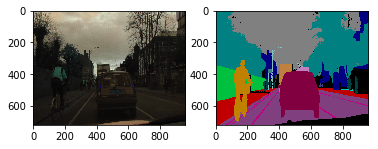

In [8]:
plt.subplot(121),plt.imshow(X_train[0])
plt.subplot(122),plt.imshow(y_train[0])

# Build Model(U-Net)

In [45]:
num_classes = 32
input_shape = (720,960,3)
smooth = 1.

In [46]:
model_checkpoint = ModelCheckpoint('model_UNET.hdf5', monitor='loss', save_best_only=True)
model_earlystopping = EarlyStopping(monitor='loss')

In [47]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [48]:
def encoder(x, layer_id, filters=64):
    s_id = 'encoder' + str(layer_id)
    
    x = Conv2D(filters, (3,3), activation='relu', padding='same', name='conv1_' + s_id)(x)
    x = Conv2D(filters, (3,3), activation='relu', padding='same', name='conv2_' + s_id)(x)
    x = BatchNormalization(name='BN_' + s_id)(x)
    xp = MaxPooling2D(pool_size=(2,2), name='pool_' + s_id)(x)
    
    return xp, x

In [49]:
def decoder(xp, x, layer_id, filters=32):
    s_id = 'decoder' + str(layer_id)
    
    x = Conv2DTranspose(filters, (2,2), strides=(2,2), name='dconv_' + s_id)(x)
    x = concatenate([xp, x], axis=-1, name='concat'+s_id)
    x = Conv2D(filters, (3,3), activation='relu', padding='same', name='conv1_' + s_id)(x)
    x = Conv2D(filters, (3,3), activation='relu', padding='same', name='conv2_' + s_id)(x)
    
    return x
    

In [50]:
def unet(nb_classes=32, input_shape=(720,960,3)):
    inputs = Input((input_shape))
    x, x1 = encoder(inputs, layer_id=1, filters=64)
    x, x2 = encoder(x, layer_id=2, filters=128)
    x, x3 = encoder(x, layer_id=3, filters=256)
    x, x4 = encoder(x, layer_id=4, filters=512)

    x = Conv2D(1024, (3,3), activation='relu', padding='same', name='conv_layer5')(x)

    x = decoder(x4, x, layer_id=4, filters=512)
    x = decoder(x3, x, layer_id=3, filters=256)
    x = decoder(x2, x, layer_id=2, filters=128)
    x = decoder(x1, x, layer_id=1, filters=64)

    x = Conv2D(nb_classes, (1,1), activation='softmax', padding='same', name='output')(x)
    
    model = Model(inputs=inputs, outputs=x)
    model.summary()
    parallel_model = multi_gpu_model(model, gpus=2)
    parallel_model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef])

    return parallel_model

In [51]:
model = unet(32, (720, 960, 3))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 720, 960, 3)  0                                            
__________________________________________________________________________________________________
conv1_encoder1 (Conv2D)         (None, 720, 960, 64) 1792        input_12[0][0]                   
__________________________________________________________________________________________________
conv2_encoder1 (Conv2D)         (None, 720, 960, 64) 36928       conv1_encoder1[0][0]             
__________________________________________________________________________________________________
BN_encoder1 (BatchNormalization (None, 720, 960, 64) 256         conv2_encoder1[0][0]             
__________________________________________________________________________________________________
pool_encod

In [53]:
model.fit(X_train, y_train, batch_size=128*2, nb_epoch=20, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint, model_earlystopping])

/home/vmadmin/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Error when checking target: expected output to have shape (None, 720, 960, 32) but got array with shape (560, 720, 960, 3)